# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling

from pymoo.optimize import minimize

from pymoo.core.termination import Termination
from pymoo.termination import get_termination

from pymoo.indicators.hv import HV

from pyDOE import lhs




# Constants
You will be interested in:
 - SAMPLE_SIZE - Controls correlation sample size, this is the sample for one dimension, so will output SAMPLE_SIZE^2 points.
 - HEATMAP_DIVISIONS - Number of divisions per dimension on all heatmap-based graphing functions.
 - POP_SIZE - population size of the EA
  - GENERATIONS - number of generations until termination

In [2]:
SAMPLE_SIZE = 200  # Number of samples along one dimension
X_RANGE = (-4, 4)  # Range for both variables
HEATMAP_DIVISIONS = 30 # Number of divisions along each axis for the correlation heatmap

POP_SIZE = 200  # Population size
GENERATIONS = 200  # Number of generations to run the algorithm
HV_THRESHOLD = 0.98  # Threshold for the hypervolume termination criterion
#-------------------------------Will need updating per problem
FF_REF_POINT = np.array([1.1, 1.1])  # Reference point for the hypervolume indicator
FF_HV_THRESHOLD = 0.5515391472311663  # Theoretical Pareto front hypervolume for the Fonseca-Fleming problem



# Set up algorithm 

In [3]:

# Fonseca-Fleming function definition
def fonseca_fleming_function(x):
    """
    Calculate the Fonseca-Fleming function values for a two-variable input.
    Args:
    x (list): A 2-element list representing the variables [x1, x2].

    Returns:
    tuple: A tuple containing the calculated values (f1, f2).
    """
    #print(x)
    #input()
    assert len(x) == 2, "Input vector must have length 2."
    term1 = np.exp(-np.sum((x - 1/np.sqrt(2))**2))
    term2 = np.exp(-np.sum((x + 1/np.sqrt(2))**2))
    f1 = 1 - term1
    f2 = 1 - term2
    #print(f"f1 = {f1}")
    #print(f"f2 = {f2}")
    #input()
    return f1, f2


class FonsecaFlemingProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([X_RANGE[0], X_RANGE[0]]), xu=np.array([X_RANGE[1], X_RANGE[1]]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1, f2 = fonseca_fleming_function(x)
        out["F"] = np.array([f1, f2])


#--------------------------------------------HV TERMINATION------------------------------------------------------------
# Termination criteria based on Hypervolume indicator
class HypervolumeTermination(Termination):
    def __init__(self, ref_point, hv_threshold = FF_HV_THRESHOLD):
        super().__init__()
        self.ref_point = ref_point
        self.hv_threshold = hv_threshold
        self.hv_indicator = HV(ref_point=FF_REF_POINT)
 
    def _do_continue(self, algorithm):
        hv = self.hv_indicator.do(algorithm.pop.get("F"))
        progress = hv / self.hv_threshold
        return hv < self.hv_threshold
 
    def _update(self, algorithm):
        hv = self.hv_indicator.do(algorithm.pop.get("F"))
        progress = hv / self.hv_threshold
        if progress >  HV_THRESHOLD:
            self.terminate()
        return progress




#--------------------------------------------ALGORITHMS------------------------------------------------------------

def optimise_function(f ,pop_size, n_gen, crossover_prob=0.9, mutation_eta=20, term_HV = False):

    problem = f

    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=10,
        sampling=FloatRandomSampling(),
        crossover=SimulatedBinaryCrossover(prob=crossover_prob, eta=15),
        mutation=PolynomialMutation(prob=1.0/problem.n_var, eta=mutation_eta),
        eliminate_duplicates=True
    )

    # 1st is the number of generations, 2nd is the HV proportion 
    if term_HV:
        termination_criterion = HypervolumeTermination(ref_point=FF_REF_POINT, hv_threshold=FF_HV_THRESHOLD)
    else:
        termination_criterion = get_termination("n_gen", n_gen)



    generations_record = []  # List to record each generation's population
    decision_variables_record = []  # List to record each generation's decision variables

    res = minimize(
        problem,
        algorithm,
        termination=termination_criterion,
        verbose=True,
        callback=lambda algo: generations_record_and_decision_variables(algo, generations_record, decision_variables_record)  # Record each generation
    )
    
    return res, generations_record, decision_variables_record


def optimize_fonseca_fleming(pop_size, n_gen, crossover_prob=0.9, mutation_eta=20, term_HV = False):

    problem = FonsecaFlemingProblem()

    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=10,
        sampling=FloatRandomSampling(),
        crossover=SimulatedBinaryCrossover(prob=crossover_prob, eta=15),
        mutation=PolynomialMutation(prob=1.0/problem.n_var, eta=mutation_eta),
        eliminate_duplicates=True
    )

    # 1st is the number of generations, 2nd is the HV proportion 
    if term_HV:
        termination_criterion = HypervolumeTermination(ref_point=FF_REF_POINT, hv_threshold=FF_HV_THRESHOLD)
    else:
        termination_criterion = get_termination("n_gen", n_gen)



    generations_record = []  # List to record each generation's population
    decision_variables_record = []  # List to record each generation's decision variables

    res = minimize(
        problem,
        algorithm,
        termination=termination_criterion,
        verbose=True,
        callback=lambda algo: generations_record_and_decision_variables(algo, generations_record, decision_variables_record)  # Record each generation
    )
    
    return res, generations_record, decision_variables_record



#stores generations and decision variables across generations
def generations_record_and_decision_variables(algo, generations_record, decision_variables_record):
    '''
    Record the objective values and decision variables for each generation.
    
    Args:
    algo (Algorithm): The algorithm object.
    generations_record (list): The list to record the objective values.
    decision_variables_record (list): The list to record the decision variables.
    
    Returns:
    None
    '''
    # Record the objective values
    generations_record.append(algo.pop.get("F"))

    # Record the decision variables
    decision_variables_record.append(algo.pop.get("X"))




# Sample with Latin Hypercube Sampling and acquire correlation

In [4]:

# Sampling function
def sample_objectives(sample_size, x_range, objective_function):
    """
    Sample a given objective function over a grid of points.

    Args:
    sample_size (int): The number of samples along one dimension, will return sample_size^2 samples.
    x_range (tuple): A tuple representing the range of variables (min, max).
    objective_function (function): The objective function to be sampled.

    Returns:
    tuple: Meshgrids for X1, X2 and their corresponding objective values.
    """
    x1_values = np.linspace(*x_range, sample_size**2)
    x2_values = np.linspace(*x_range, sample_size**2)
    X1, X2 = np.meshgrid(x1_values, x2_values)
    Z1, Z2 = np.zeros(X1.shape), np.zeros(X2.shape)

    for i in range(sample_size):
        for j in range(sample_size):
            Z1[i, j], Z2[i, j] = objective_function([X1[i, j], X2[i, j]])
    
    return X1, X2, Z1, Z2




def sample_objectives_lhs(sample_size, x_range, objective_class):
    """
    Sample a given objective function using Latin Hypercube Sampling and return
    in the format similar to grid-based sampling.

    Args:
        sample_size (int): The square root of the number of samples (sample_size x sample_size).
        x_range (tuple): A tuple representing the range of variables (min, max).
        objective_function (function): The objective function to be sampled.

    Returns:
        tuple: Meshgrids for X1, X2 and their corresponding Z1, Z2 values.
    """
    num_samples = sample_size ** 2
    lhd = lhs(2, samples=num_samples)
    scaled_samples = lhd * (x_range[1] - x_range[0]) + x_range[0]

    problem_instance = objective_class

    # Reshape the samples to form meshgrids
    x1_values = scaled_samples[:, 0].reshape(sample_size, sample_size)
    x2_values = scaled_samples[:, 1].reshape(sample_size, sample_size)
    Z1, Z2 = np.zeros(x1_values.shape), np.zeros(x2_values.shape)

    for i in range(sample_size):
        for j in range(sample_size):
            out = {"F": None}
            problem_instance._evaluate([x1_values[i, j], x2_values[i, j]], out)
            Z1[i, j], Z2[i, j] = out["F"]

    return x1_values, x2_values, Z1, Z2



def assign_correlations(X1, X2, Z1, Z2, divisions):
    """
    Assign a correlation value to each objective value and their corresponding decision space values.

    Args:
    X1, X2, Z1, Z2 (ndarray): Meshgrids for the decision variables and objective function values.
    divisions (int): The number of divisions along each axis for the grid.

    Returns:
    ndarray: A numpy array containing the correlation for each point in the decision space.
    """
    correlation_matrix = np.zeros(Z1.shape)
    x_step = (Z1.max() - Z1.min()) / divisions
    y_step = (Z2.max() - Z2.min()) / divisions

    for i in range(divisions):
        for j in range(divisions):
            x_min, x_max = Z1.min() + i * x_step, Z1.min() + (i + 1) * x_step
            y_min, y_max = Z2.min() + j * y_step, Z2.min() + (j + 1) * y_step
            mask = (Z1 >= x_min) & (Z1 < x_max) & (Z2 >= y_min) & (Z2 < y_max)
            if np.any(mask) and np.std(Z1[mask]) != 0 and np.std(Z2[mask]) != 0:
                corr_coef = np.corrcoef(Z1[mask], Z2[mask])[0, 1]
                correlation_matrix[mask] = corr_coef
            else:
                correlation_matrix[mask] = np.nan  # Assign NaN where there's no data or insufficient variation Assign NaN where there's no data

    return correlation_matrix





# Produce correlation figures

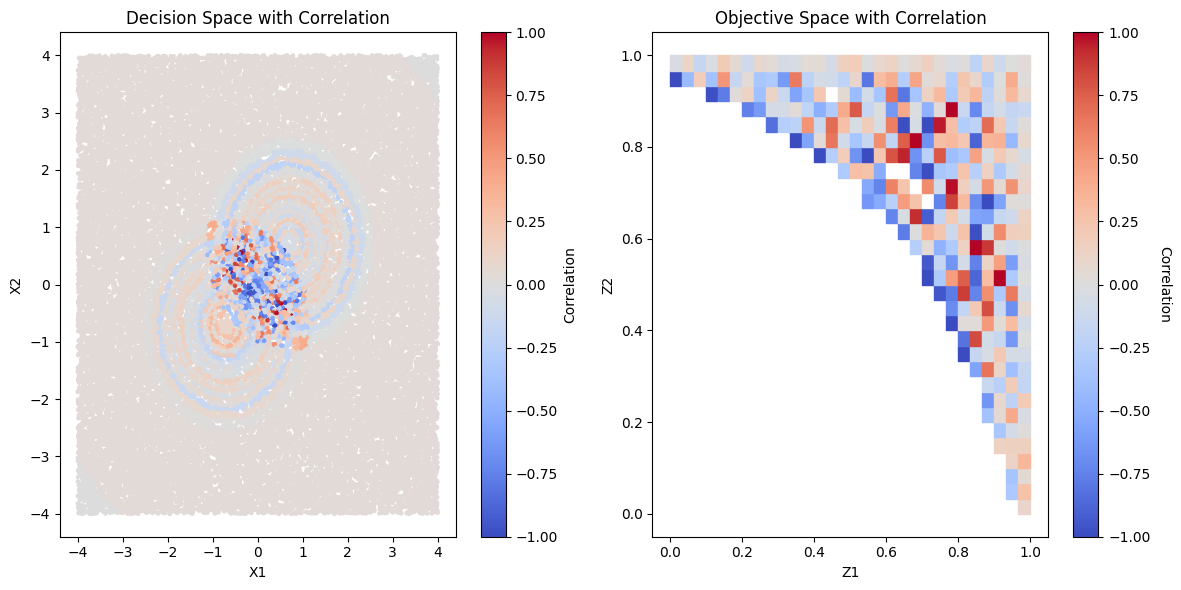

In [5]:

def plot_decision_space_correlation(X1, X2, correlations, ax = None):
    """
    Plot the decision space with each point colored according to its correlation.

    Args:
    X1, X2 (ndarray): Arrays for the decision variables.
    correlations (ndarray): Correlation values for each point.

    Returns:
    None: This function will directly plot the decision space.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    norm = Normalize(vmin=-1, vmax=1)  # Normalization bounds set to -1 and 1
    scatter = ax.scatter(X1, X2, c=correlations, cmap='coolwarm', norm=norm, s=5)
    fig.colorbar(scatter, ax = ax, label='Correlation')
    ax.set_title('Decision Space with Correlation')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    return ax



def plot_objective_space_correlation(Z1, Z2, correlations, divisions=HEATMAP_DIVISIONS, add_count=False, ax=None):
    """
    Plot the objective space with each subspace colored according to its pre-computed correlation.
    Returns the correlation matrix for each cell.

    Args:
    Z1, Z2 (ndarray): Meshgrids for the objective function values.
    correlations (ndarray): Pre-computed correlation values for each point.
    divisions (int): Number of divisions along each axis for the grid.

    Returns:
    ndarray: A matrix containing the correlation value for each cell.
    """
    x_step = (Z1.max() - Z1.min()) / divisions
    y_step = (Z2.max() - Z2.min()) / divisions
    cmap = plt.get_cmap('coolwarm')
    norm = Normalize(vmin=-1, vmax=1)
    correlation_matrix = np.zeros((divisions, divisions))  # Initialize the correlation matrix

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    for i in range(divisions):
        for j in range(divisions):
            x_min, x_max = Z1.min() + i * x_step, Z1.min() + (i + 1) * x_step
            y_min, y_max = Z2.min() + j * y_step, Z2.min() + (j + 1) * y_step
            mask = (Z1 >= x_min) & (Z1 < x_max) & (Z2 >= y_min) & (Z2 < y_max)
            masked_correlations = correlations[mask]
            if np.any(~np.isnan(masked_correlations)):
                alpha = np.nanmean(masked_correlations)
                correlation_matrix[i, j] = alpha
                color = cmap(norm(alpha)) if not np.isnan(alpha) else 'white'
            else:
                correlation_matrix[i, j] = np.nan
                color = 'white'

            ax.fill_betweenx([y_min, y_max], x_min, x_max, color=color)
            if add_count and not np.isnan(correlation_matrix[i, j]):
                count = np.sum(mask)
                ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, str(count),
                        ha='center', va='center', fontsize=8, color='black')

    ax.set_title('Objective Space with Correlation')
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    cbar = plt.colorbar(mappable, ax=ax, label='Correlation')
    cbar.set_label('Correlation', rotation=270, labelpad=15)

    return ax, correlation_matrix







def correlation_figures(f):
    # Sample the Fonseca-Fleming function using lhs
    X1, X2, Z1, Z2 = sample_objectives_lhs(SAMPLE_SIZE, X_RANGE, f)

    # Assign correlation values to each point in the decision space
    correlations = assign_correlations(X1, X2, Z1, Z2, HEATMAP_DIVISIONS)

    fig_correlation, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the decision space with each point colored according to its correlation
    plot_decision_space_correlation(X1, X2, correlations, ax = ax1)

    # Plot the objective space with each subspace colored according to its correlation
    ax2, correlation_matrix = plot_objective_space_correlation(Z1, Z2, correlations, add_count=False, ax=ax2)

    #save and show the plot
    plt.tight_layout()
    fig_correlation.savefig('correlation_plots.png')
    plt.show()
    plt.close()

    return correlation_matrix



correlation_matrix = correlation_figures(FonsecaFlemingProblem())


# Create the heatmaps from a run of the algorithm

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      6 |             - |             -
     2 |      210 |      6 |  0.000000E+00 |             f
     3 |      220 |      6 |  0.0221875617 |             f
     4 |      230 |      7 |  0.0139940542 |             f
     5 |      240 |      7 |  0.000000E+00 |             f
     6 |      250 |      7 |  0.000000E+00 |             f
     7 |      260 |      8 |  0.0087536217 |             f
     8 |      270 |      8 |  0.000000E+00 |             f
     9 |      280 |      8 |  0.000000E+00 |             f
    10 |      290 |      9 |  0.0091170180 |             f
    11 |      300 |      9 |  0.000000E+00 |             f
    12 |      310 |      9 |  0.000000E+00 |             f
    13 |      320 |      9 |  0.000000E+00 |             f
    14 |      330 |     10 |  0.0033847316 |             f
    15 |      340 |     10 |  0.000000E+00 |             f
    16 |      350 |     11 |  0.0066228216 |            

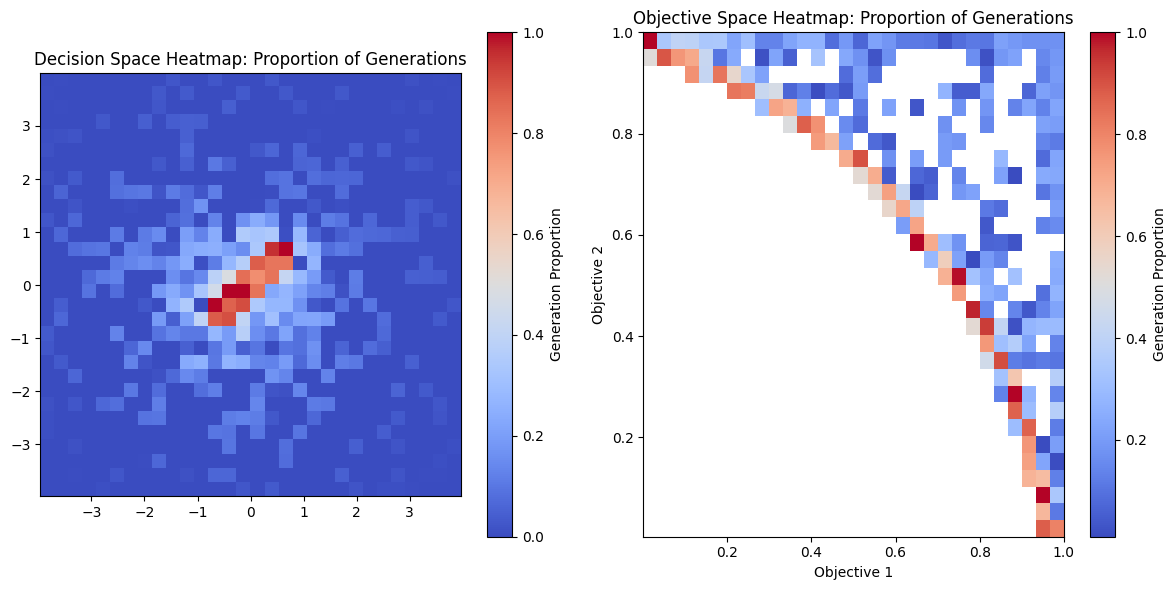

In [6]:


def plot_instance_proportion_by_division(results_by_generation, num_divisions=200, ax=None, show_numbers=False):
    """
    Plots the objective space, color-coded by the proportion of generations that have at least one instance in each subsection.
    Each cell is annotated with the earliest generation in which it was filled.
    Empty subsections are shown in white.

    :param results_by_generation: List of lists, where each inner list contains objective values for a generation.
    :param num_divisions: Number of divisions for each objective in the grid.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    all_results = np.vstack(results_by_generation)
    max_values = np.max(all_results, axis=0)
    min_values = np.min(all_results, axis=0)

    grids = [np.linspace(min_values[i], max_values[i], num_divisions + 1) for i in range(all_results.shape[1])]

    hit_counts = np.zeros([num_divisions] * all_results.shape[1])
    earliest_generation = np.full([num_divisions] * all_results.shape[1], np.inf)

    for gen_index, generation in enumerate(results_by_generation):
        generation_hits = np.zeros_like(hit_counts, dtype=bool)
        for point in generation:
            indices = [np.searchsorted(grids[i], point[i], side='right') - 1 for i in range(len(point))]
            valid_indices = [0 <= idx < num_divisions for idx in indices]
            if all(valid_indices):
                if generation_hits[tuple(indices)] == False:
                    earliest_generation[tuple(indices)] = min(earliest_generation[tuple(indices)], gen_index + 1)
                generation_hits[tuple(indices)] = True
        hit_counts += generation_hits

    proportion_grid = hit_counts / len(results_by_generation)

    if all_results.shape[1] == 2:
        cmap = plt.cm.coolwarm
        cmap.set_under(color='white', alpha=0)
        im = ax.imshow(proportion_grid.T, cmap=cmap, origin='lower',
                       extent=[min_values[0], max_values[0], min_values[1], max_values[1]],
                       aspect='auto', vmin=0.01)

        # Annotate each cell with the earliest generation it was filled
        cell_width = (max_values[0] - min_values[0]) / num_divisions
        cell_height = (max_values[1] - min_values[1]) / num_divisions
        if show_numbers == True:
            for (i, j), val in np.ndenumerate(earliest_generation):
                if val != np.inf:
                    ax.text(min_values[0] + (i + 0.5) * cell_width, 
                            min_values[1] + (j + 0.5) * cell_height, 
                            int(val), ha='center', va='center', fontsize=4, color='black')

        fig.colorbar(im, ax=ax, label='Generation Proportion')
        ax.set_xlabel('Objective 1')
        ax.set_ylabel('Objective 2')
        ax.set_title('Objective Space Heatmap: Proportion of Generations')
    else:
        raise NotImplementedError("Plotting for dimensions other than 2 is not implemented.")
    
    return ax, proportion_grid


def decision_space_proportion_and_earliest_heatmap(decision_data, divisions=HEATMAP_DIVISIONS, ax=None):
    """
    Create a heatmap based on the proportion of generations with at least one instance within subspaces of the decision space.
    Annotate each cell with the number of the earliest generation where an instance was present.

    Args:
    decision_data (list): Nested lists in the structure [generations [populations of generation [decision variables]]].
    divisions (int): The number of divisions along each axis for the grid.

    Returns:
    None: This function will directly plot the heatmap.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    all_data = np.vstack([np.vstack(generation) for generation in decision_data])
    D1 = all_data[:, 0]
    D2 = all_data[:, 1]

    d1_min, d1_max = D1.min(), D1.max()
    d2_min, d2_max = D2.min(), D2.max()

    proportion_matrix = np.zeros((divisions, divisions))
    earliest_generation_matrix = np.full((divisions, divisions), np.inf)
    total_generations = len(decision_data)

    d1_step = (d1_max - d1_min) / divisions
    d2_step = (d2_max - d2_min) / divisions

    for gen_index, generation in enumerate(decision_data):
        gen_data = np.vstack(generation)
        D1_gen = gen_data[:, 0]
        D2_gen = gen_data[:, 1]

        for i in range(divisions):
            for j in range(divisions):
                d1_lower_bound = d1_min + i * d1_step
                d1_upper_bound = d1_min + (i + 1) * d1_step
                d2_lower_bound = d2_min + j * d2_step
                d2_upper_bound = d2_min + (j + 1) * d2_step

                mask = (D1_gen >= d1_lower_bound) & (D1_gen < d1_upper_bound) & (D2_gen >= d2_lower_bound) & (D2_gen < d2_upper_bound)
                if np.any(mask):
                    proportion_matrix[i, j] += 1
                    if earliest_generation_matrix[i, j] == np.inf:
                        earliest_generation_matrix[i, j] = gen_index + 1

    proportion_matrix /= total_generations

    im = ax.imshow(proportion_matrix.T, cmap='coolwarm', origin='lower', aspect='equal', extent=[d1_min, d1_max, d2_min, d2_max])
    fig.colorbar(im, ax=ax, label='Generation Proportion')


    ax.set_title('Decision Space Heatmap: Proportion of Generations')

    return ax







def count_prop_figures(f):
    # Optimize the Fonseca-Fleming function using NSGA-II
    res, generations, decision_variables = optimise_function(f, POP_SIZE, GENERATIONS)

    fig_instance_count, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    #plot the instance proportion by division for the decision space
    decision_space_proportion_and_earliest_heatmap(decision_variables, HEATMAP_DIVISIONS, ax=ax1)

    #plot the instance proportion by division for the objective space
    ax2, proportion_grid = plot_instance_proportion_by_division(generations, HEATMAP_DIVISIONS, ax=ax2)

    plt.tight_layout()
    fig_instance_count.savefig('instance_proportion_plots_200.png')
    plt.show()
    plt.close()

    return proportion_grid


proportion_grid = count_prop_figures(FonsecaFlemingProblem())


# OVERLAYED GRAPHS

The normalisation feature, and the operation between the two needs to be improved.

<Axes: title={'center': 'Correlation Heatmap minus Instance Proportion Heatmap'}, xlabel='Objective 1', ylabel='Objective 2'>

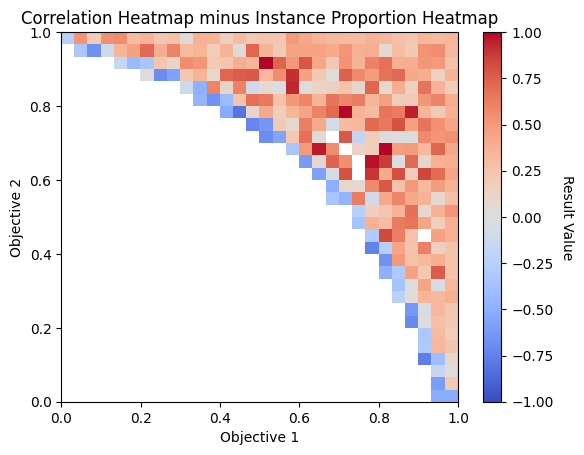

In [7]:

#acquire data matrices for objective space

#each should be a list of lists, with dimensions of [HEATMAP_DIVISIONS x HEATMAP_DIVISIONS]

def get_matrices_from_corr_and_prop ():
    """
    Processes and combines the global correlation matrix and proportion grid.

    This function converts the global correlation matrix to a NumPy array and normalizes its values 
    to be between 0 and 1. It then subtracts the proportion grid from this normalized correlation matrix. 
    In the resulting matrix, if a value in the original correlation matrix is NaN, it remains NaN. 

    The function assumes that the global variables 'correlation_matrix' and 'proportion_grid' are NumPy arrays 
    of the same shape and are accessible in the global scope.

    Returns:
        result_matrix (np.ndarray): A NumPy array representing the result of subtracting the proportion grid
                                    from the normalized correlation matrix. The shape of the result matrix 
                                    is the same as that of the correlation matrix and proportion grid.
    """
    global correlation_matrix, proportion_grid

    #convert correlation matrix to numpy array
    correlation_matrix = np.array(correlation_matrix)
    #normalise correlation values to be between 0 and 1
    correlation_matrix_new = (correlation_matrix + 1) / 2

    # combine the two matrices
    result_matrix = np.where(np.isnan(correlation_matrix_new), np.nan, correlation_matrix_new - proportion_grid)
    return result_matrix



def plot_result_matrix(result_matrix, num_divisions=HEATMAP_DIVISIONS, ax=None):
    """
    Plots the objective space with values from the result matrix, setting colormap bounds from -1 to 1.

    :param result_matrix: The matrix containing the computed values to be plotted.
    :param num_divisions: Number of divisions for each objective in the grid.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    # Set colormap bounds from -1 to 1
    norm = Normalize(vmin=-1, vmax=1)

    # Define the colormap for the plot
    cmap = plt.cm.coolwarm  # Matching the colormap with your existing style

    # Define the extent for the plot (adjust this as per your objective space range)
    extent = [0, 1, 0, 1]  # Adjust if needed

    # Create the heatmap
    im = ax.imshow(result_matrix, cmap=cmap, norm=norm, origin='lower', extent=extent, aspect='auto')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label='Result Value')
    cbar.set_label('Result Value', rotation=270, labelpad=15)

    # Set labels and title
    ax.set_xlabel('Objective 1')
    ax.set_ylabel('Objective 2')
    ax.set_title('Correlation Heatmap minus Instance Proportion Heatmap')

    return ax






result_matrix = get_matrices_from_corr_and_prop()

# Example usage (make sure to replace 'result_matrix' with your actual result matrix variable)
plot_result_matrix(result_matrix, num_divisions=HEATMAP_DIVISIONS)


# Forming BBOB-BIOBJ problems


In [8]:
import torch
import bbobtorch


# Placeholder for the BBOB Attractive Sector function (f6)
def bbob_f6_function(x):
    def bbob_f6_transformation(x, alpha=10):
        """
        Transformation for the BBOB Attractive Sector function (f6).
        Args:
            x (numpy.array): Input variables.
            alpha (float): Scaling factor for the non-attractive sector.
        Returns:
            numpy.array: Transformed variables.
        """
        z = np.empty_like(x)
        for i in range(len(x)):
            if x[i] > 0:
                z[i] = x[i]  # No scaling in the attractive sector
            else:
                z[i] = alpha * x[i]  # Scaling in the non-attractive sector
        return z
    """
    Placeholder for the BBOB Attractive Sector function.
    Replace with the actual implementation.
    Args:
        x (list): A 2-element list representing the variables [x1, x2].
    Returns:
        float: The function value at `x`.
    """
    # Placeholder transformation (actual transformation will be more complex)

    z = bbob_f6_transformation(x)
    return np.sum(z**2)



def BBOB_f20(x):
    """
    Bi-objective combination of two BBOB Attractive Sector functions.
    Args:
        x (list): A 2-element list representing the variables [x1, x2].
    Returns:
        tuple: A tuple containing the calculated values (f1, f2).
    """
    assert len(x) == 2, "Input vector must have length 2."
    x = np.asarray(x)
    f1 = bbob_f6_function(x)
    f2 = bbob_f6_function(-x)  # A simple inversion, adjust as needed for the bi-objective case
    return f1, f2





class BBOBf20(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([X_RANGE[0], X_RANGE[0]]), xu=np.array([X_RANGE[1], X_RANGE[1]]))
        self.fn = bbobtorch.create_f20(2, seed=42)  # Adjust the function number if needed

    def _evaluate(self, x, out, *args, **kwargs):
        x_torch = torch.tensor(x, dtype=torch.float32)
        f1 = self.fn(x_torch)
        f2 = self.fn(-x_torch)
        out["F"] = np.array([f1.item(), f2.item()])  # Convert to numpy array


def bbob_f20_function(x):
    fn = bbobtorch.create_f20(2, seed=42)  # Adjust as necessary
    x_torch = torch.tensor(x, dtype=torch.float32)
    f1 = fn(x_torch)
    f2 = fn(-x_torch)
    return f1.item(), f2.item()



class BBOBf24(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([X_RANGE[0], X_RANGE[0]]), xu=np.array([X_RANGE[1], X_RANGE[1]]))
        self.fn = bbobtorch.create_f24(2, seed=42)  # Adjust the function number if needed

    def _evaluate(self, x, out, *args, **kwargs):
        x_torch = torch.tensor(x, dtype=torch.float32)
        f1 = self.fn(x_torch)
        f2 = self.fn(-x_torch)
        out["F"] = np.array([f1.item(), f2.item()])  # Convert to numpy array


class BBOBf8(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([X_RANGE[0], X_RANGE[0]]), xu=np.array([X_RANGE[1], X_RANGE[1]]))
        self.fn = bbobtorch.create_f08(2, seed=42)  # Adjust the function number if needed

    def _evaluate(self, x, out, *args, **kwargs):
        x_torch = torch.tensor(x, dtype=torch.float32)
        f1 = self.fn(x_torch)
        f2 = self.fn(-x_torch)
        out["F"] = np.array([f1.item(), f2.item()])  # Convert to numpy array


class BBOBf12(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([X_RANGE[0], X_RANGE[0]]), xu=np.array([X_RANGE[1], X_RANGE[1]]))
        self.fn = bbobtorch.create_f12(2, seed=42)  # Adjust the function number if needed

    def _evaluate(self, x, out, *args, **kwargs):
        x_torch = torch.tensor(x, dtype=torch.float32)
        f1 = self.fn(x_torch)
        f2 = self.fn(-x_torch)
        out["F"] = np.array([f1.item(), f2.item()])  # Convert to numpy array







# Final Figures


BBOB 20


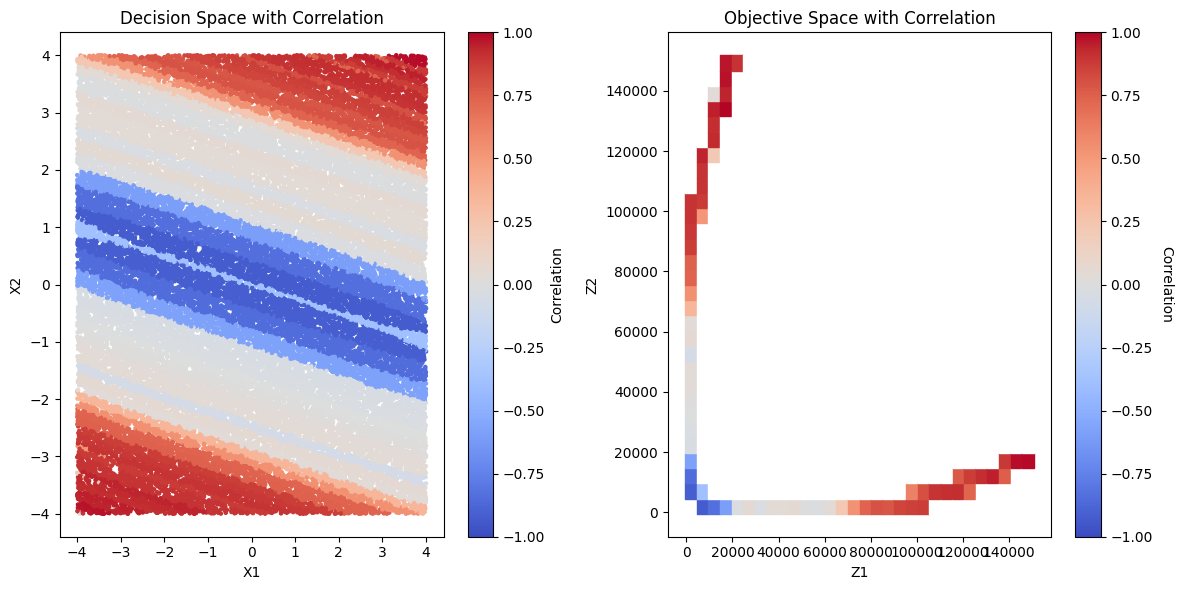

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     57 |             - |             -
     2 |      210 |     59 |  0.0002400550 |             f
     3 |      220 |     62 |  0.0006146782 |             f
     4 |      230 |     62 |  0.0006146782 |             f
     5 |      240 |     63 |  0.0007125681 |             f
     6 |      250 |     68 |  0.0016179652 |             f
     7 |      260 |     69 |  0.0016572413 |             f
     8 |      270 |     71 |  0.0017873589 |             f
     9 |      280 |     73 |  0.0022436055 |             f
    10 |      290 |     73 |  0.0022436055 |             f
    11 |      300 |     74 |  0.0022637822 |             f
    12 |      310 |     74 |  0.0052658383 |         nadir
    13 |      320 |     75 |  0.0000646822 |             f
    14 |      330 |     77 |  0.0002667542 |             f
    15 |      340 |     74 |  0.0004325980 |             f
    16 |      350 |     76 |  0.0005438780 |            

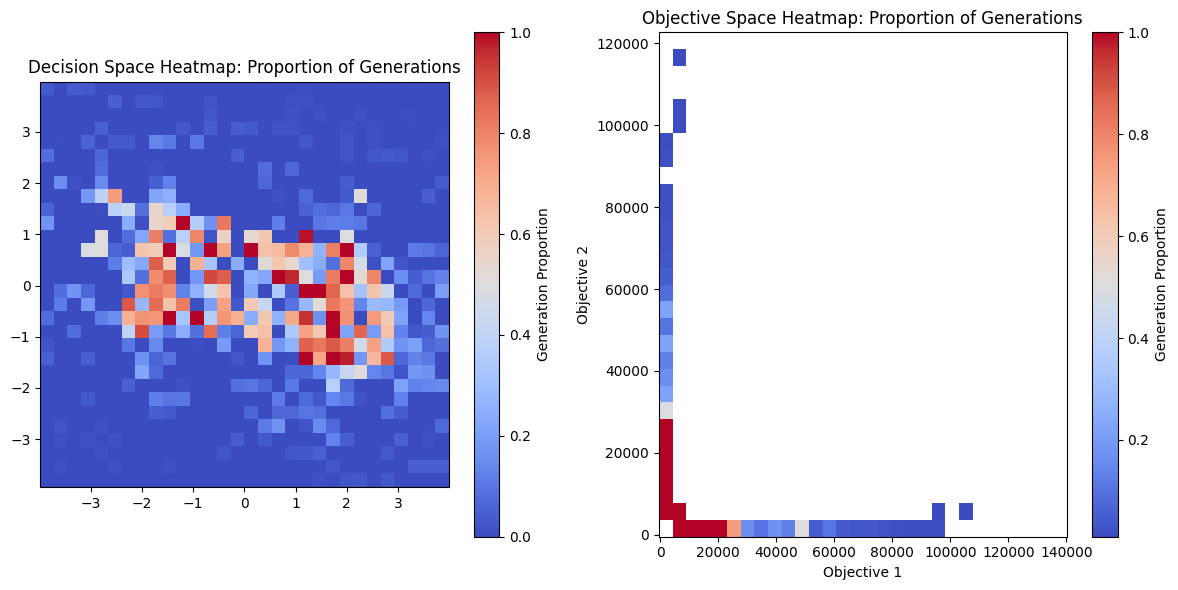

BBOB 24


C:\Users\TheodoreProctor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2432.)
  R, _ = t.qr(R)


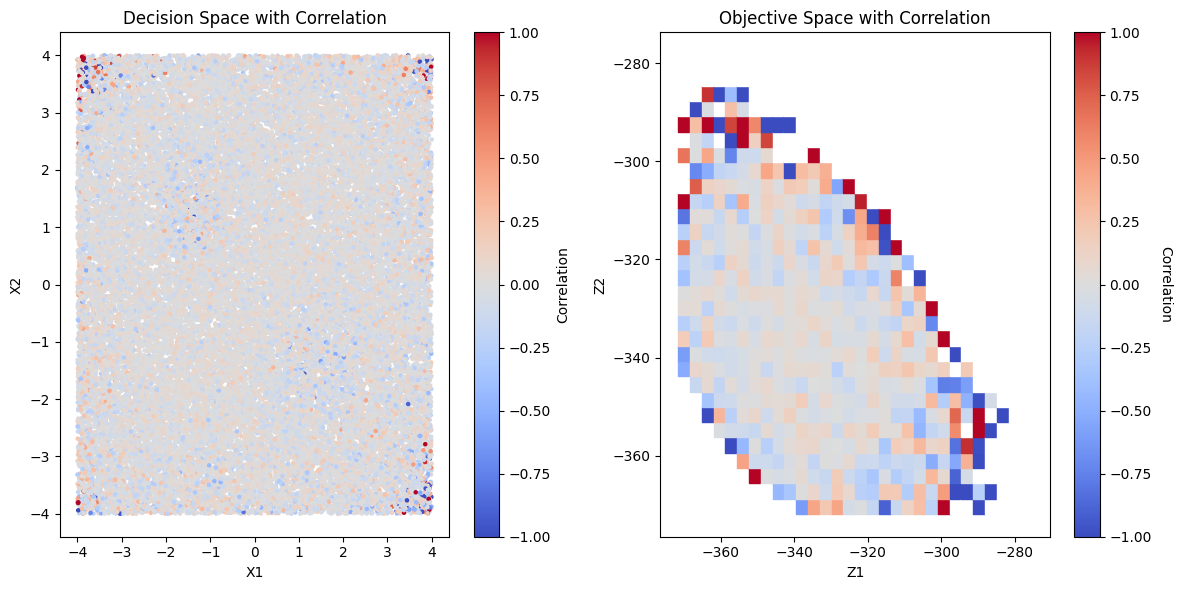

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     11 |             - |             -
     2 |      210 |     10 |  0.0180456189 |         ideal
     3 |      220 |     10 |  0.000000E+00 |             f
     4 |      230 |      9 |  0.0320172972 |         ideal
     5 |      240 |     10 |  0.0195391037 |             f
     6 |      250 |     10 |  0.000000E+00 |             f
     7 |      260 |     12 |  0.0072608803 |             f
     8 |      270 |     12 |  0.000000E+00 |             f
     9 |      280 |     12 |  0.0039883677 |             f
    10 |      290 |     12 |  0.000000E+00 |             f
    11 |      300 |     13 |  0.0082325851 |             f
    12 |      310 |     13 |  0.0007730223 |             f
    13 |      320 |     13 |  0.0007730223 |             f
    14 |      330 |     13 |  0.0007730223 |             f
    15 |      340 |     13 |  0.0007730223 |             f
    16 |      350 |     13 |  0.0007730223 |            

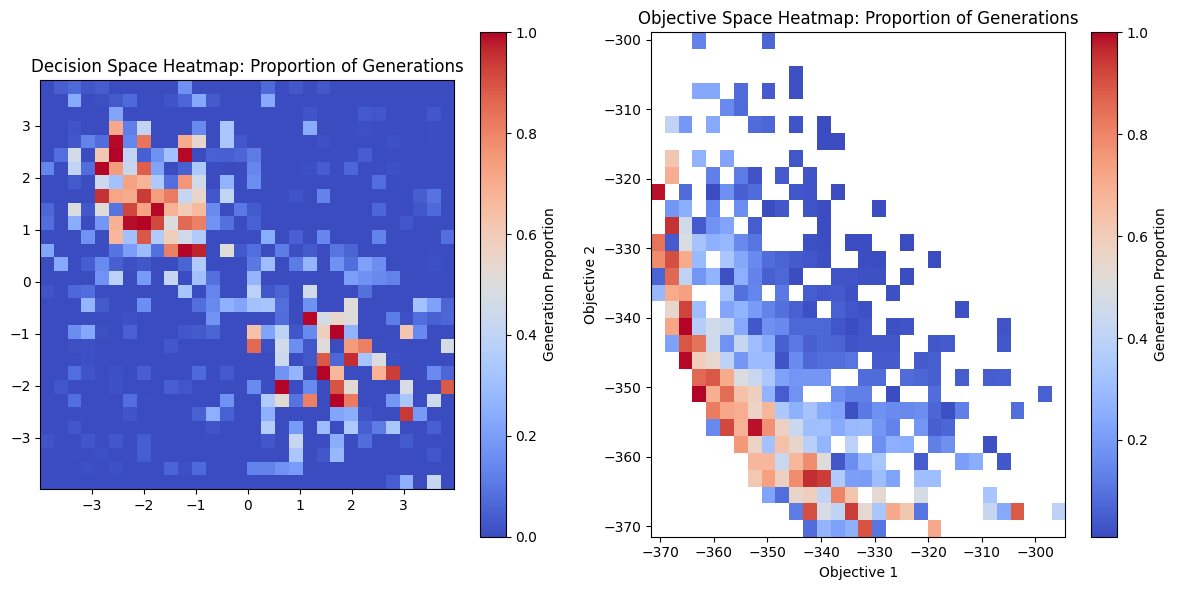

BBOB 8


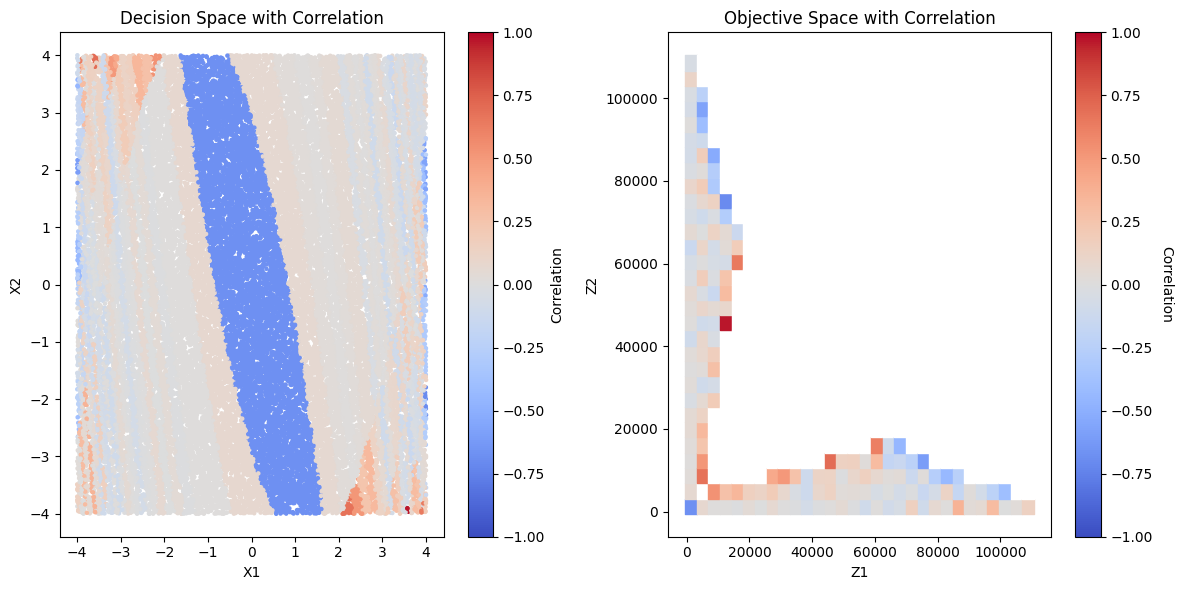

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     21 |             - |             -
     2 |      210 |     22 |  0.0001372576 |             f
     3 |      220 |     25 |  0.0041639215 |             f
     4 |      230 |     27 |  0.0002114005 |             f
     5 |      240 |     27 |  0.0002114005 |             f
     6 |      250 |     29 |  0.0007380403 |             f
     7 |      260 |     29 |  0.0010787700 |             f
     8 |      270 |     31 |  0.0055468495 |             f
     9 |      280 |     32 |  0.0007818370 |             f
    10 |      290 |     35 |  0.0012848837 |             f
    11 |      300 |     36 |  0.0017985578 |             f
    12 |      310 |     38 |  0.0024105608 |             f
    13 |      320 |     38 |  0.0024105608 |             f
    14 |      330 |     39 |  0.0023525409 |             f
    15 |      340 |     40 |  0.0053292559 |             f
    16 |      350 |     41 |  0.0000515571 |            

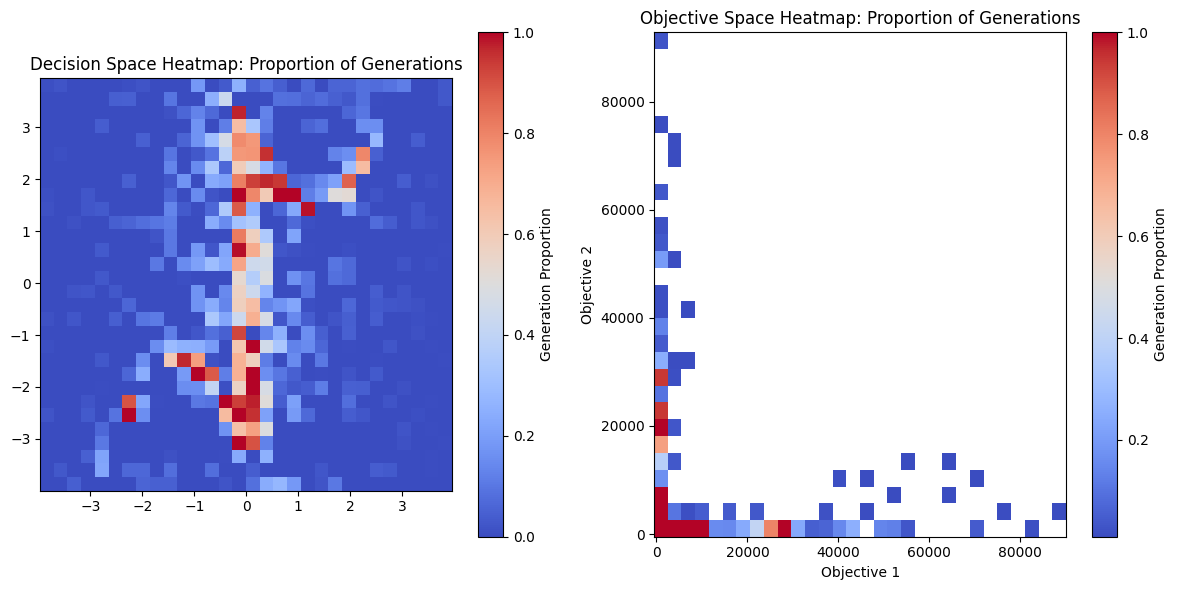

BBOB 5


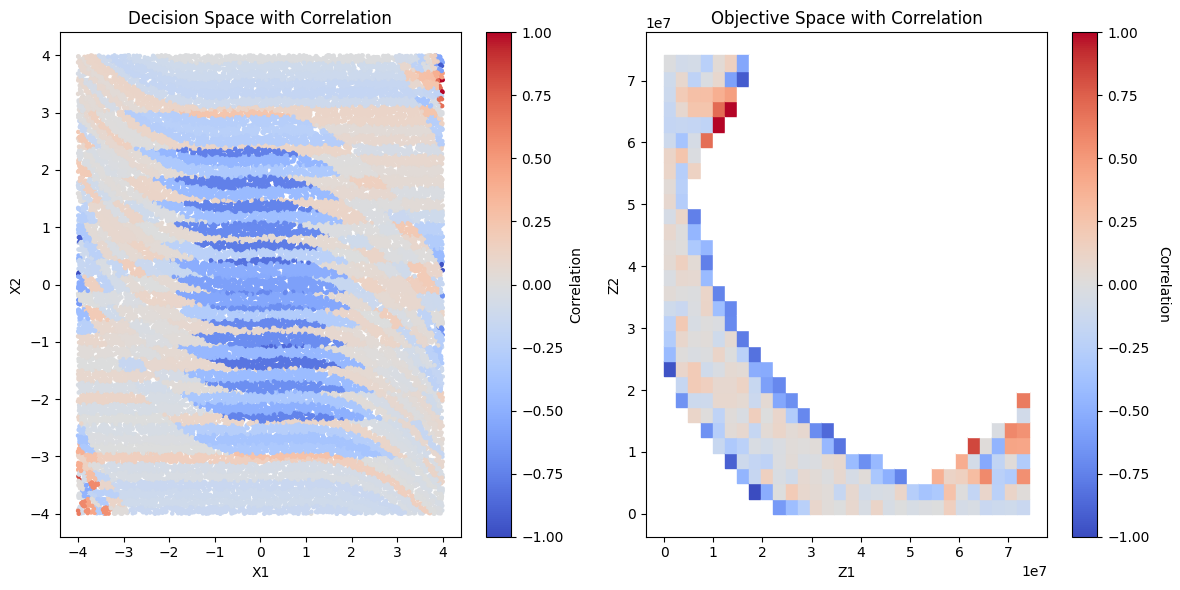

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     22 |             - |             -
     2 |      210 |     20 |  0.0034974305 |             f
     3 |      220 |     20 |  0.000000E+00 |             f
     4 |      230 |     21 |  0.0003435112 |             f
     5 |      240 |     22 |  0.0005825462 |             f
     6 |      250 |     22 |  0.0005825462 |             f
     7 |      260 |     22 |  0.0005825462 |             f
     8 |      270 |     23 |  0.0009625946 |             f
     9 |      280 |     23 |  0.0009625946 |             f
    10 |      290 |     23 |  0.0009625946 |             f
    11 |      300 |     26 |  0.0024487668 |             f
    12 |      310 |     26 |  0.0024487668 |             f
    13 |      320 |     25 |  0.0075374172 |             f
    14 |      330 |     23 |  0.5619888565 |         nadir
    15 |      340 |     23 |  0.000000E+00 |             f
    16 |      350 |     24 |  0.0005767537 |            

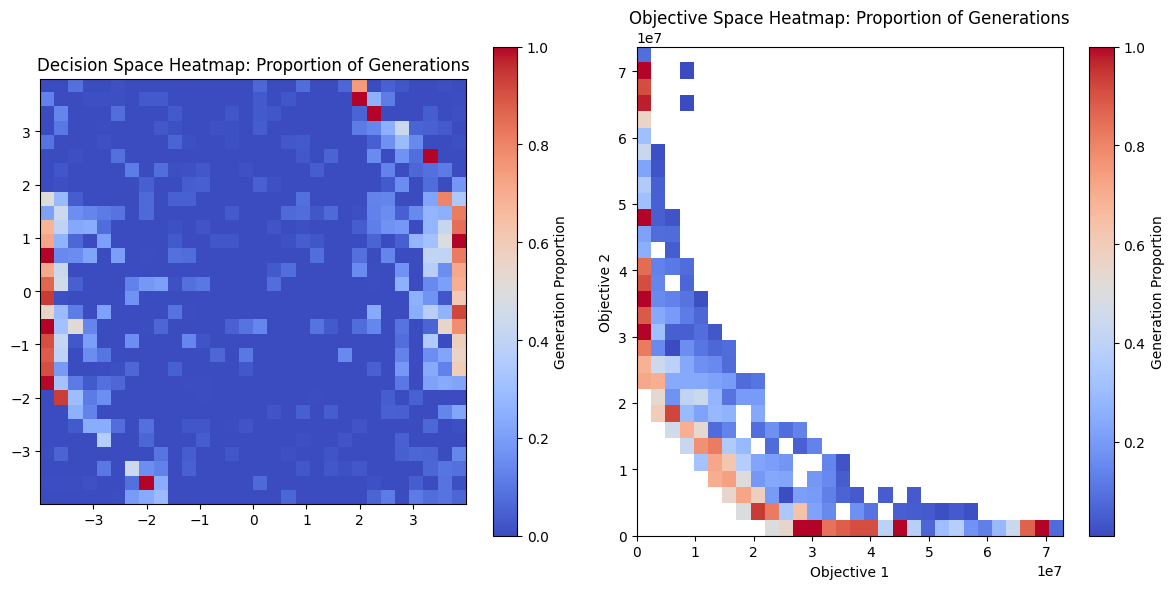

Fonseca Fleming


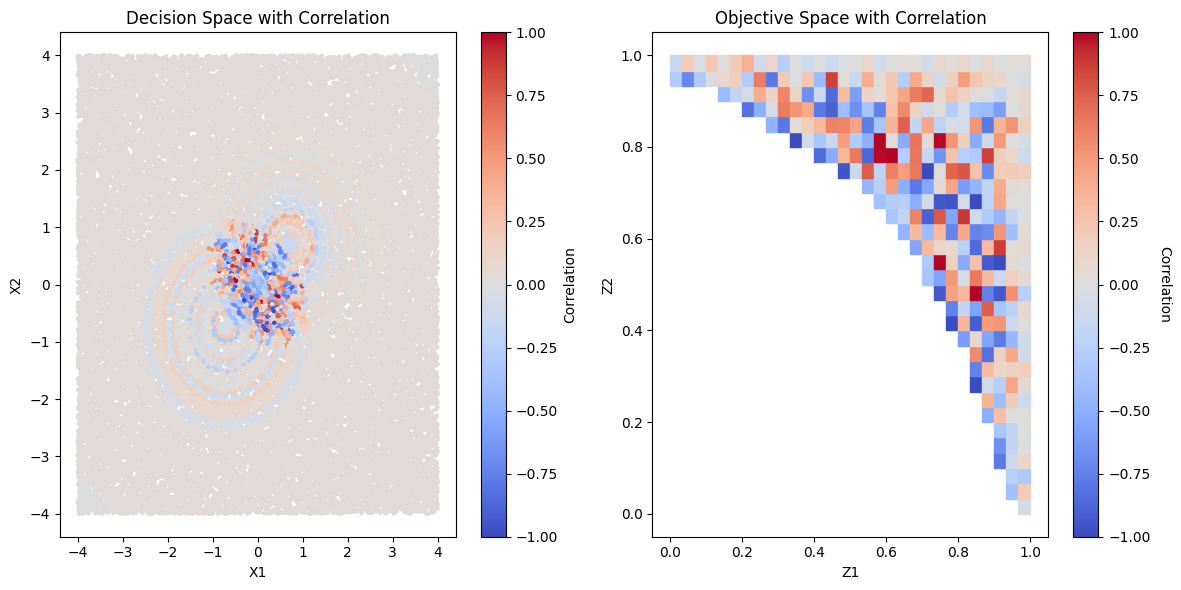

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      7 |             - |             -
     2 |      210 |      9 |  0.0217532909 |             f
     3 |      220 |      9 |  0.000000E+00 |             f
     4 |      230 |      9 |  0.000000E+00 |             f
     5 |      240 |      9 |  0.000000E+00 |             f
     6 |      250 |      9 |  0.000000E+00 |             f
     7 |      260 |     10 |  0.0041128090 |             f
     8 |      270 |     10 |  0.000000E+00 |             f
     9 |      280 |     10 |  0.000000E+00 |             f
    10 |      290 |     10 |  0.0033798216 |             f
    11 |      300 |     12 |  0.0161327358 |             f
    12 |      310 |     14 |  0.0313641932 |         ideal
    13 |      320 |     13 |  0.0034077910 |             f
    14 |      330 |     16 |  0.0135966395 |             f
    15 |      340 |     16 |  0.000000E+00 |             f
    16 |      350 |     17 |  0.0014141651 |            

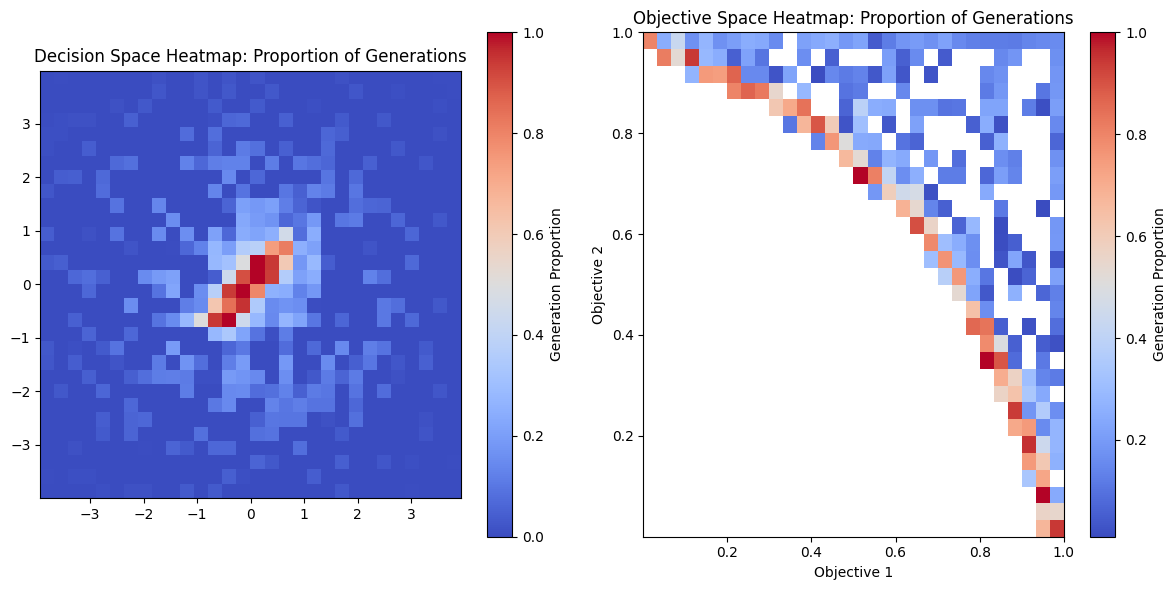

In [9]:




print("BBOB 20")
correlation_matrix = correlation_figures(BBOBf20())
prop_count_grid = count_prop_figures(BBOBf20())

print("BBOB 24")
correlation_matrix = correlation_figures(BBOBf24())
prop_count_grid = count_prop_figures(BBOBf24())

print("BBOB 8")
correlation_matrix = correlation_figures(BBOBf8())
prop_count_grid = count_prop_figures(BBOBf8())

print("BBOB 5")
correlation_matrix = correlation_figures(BBOBf12())
prop_count_grid = count_prop_figures(BBOBf12())

print("Fonseca Fleming")
correlation_matrix = correlation_figures(FonsecaFlemingProblem())
prop_count_grid = count_prop_figures(FonsecaFlemingProblem())
